In [1]:
import numpy as np
from functools import partialmethod
np.random.seed(1)


In [2]:
class Tensor(object):
    def __init__(self, data, requires_grad=True):
        self.requires_grad = requires_grad
        self.grad = None
        self._ctx = None
        
        if isinstance(data, list):
            data = np.array(data).astype(np.float32)
        elif isinstance(data, np.ndarray):
            data = data.astype(np.float32)
        elif isinstance(data, np.float32) or isinstance(data, np.uint8):
            data = np.array([data]).astype(data.dtype)
        else:
            raise ValueError(
            f'unknown data instance passed to Tensor.__init__, {type(data)}')
        
        self.data = data
    
    def __repr__(self):
        return f'<{self.__class__.__module__}.{self.__class__.__qualname__}\n{self.data}>'
    
    def __str__(self):
        return f'<autograd.Tensor\n{self.data}\ndtype={self.dtype}, grad_fn={self._ctx}, grad={self.grad}>'
    
    @property
    def shape(self):
        return self.data.shape
    
    @property
    def dtype(self):
        return self.data.dtype
    
    def uint8(self):
        self.data = self.data.astype(np.uint8)
        return self
    
    def float32(self):
        self.data = self.data.astype(np.float32)
        return self
    
    @classmethod
    def ones(cls, *shape, **kwargs):
        return cls(np.ones(shape), **kwargs)
    
    @classmethod
    def zeros(cls, *shape, **kwargs):
        return cls(np.zeros(shape), **kwargs)
    
    @classmethod
    def uniform(cls, *shape, **kwargs):
        return cls((np.random.uniform(-1.0, 1.0, size=shape)
                   / np.sqrt(np.prod(shape))).astype(np.float32), **kwargs)
    
    def mean(self):
        return self.sum(keepdims=False).mul(Tensor([1.0 / np.prod(self.shape)]))
    
    def logsoftmax(self):
        return self.sub(self.exp().sum(axis=1).log())
    
    def backward(self, allow_fill=True):
        if self._ctx is None:
            return
        
        if self.grad is None and allow_fill:
            self.grad = np.ones_like(self.data)
        
        tensors = self._ctx.parents
        gradients = self._ctx.backward(self.grad)
        gradients = [gradients] if len(tensors) == 1 else gradients
        
        for gradient, tensor in zip(gradients, tensors):
            if gradient is None:
                continue
                
            tensor.grad = gradient
            tensor.backward(allow_fill=False)


In [34]:
class Function(object):
    def __init__(self, *tensors):
        self.parents = tensors
        self.saved_tensors = []
        self.requires_grad = any([tensor.requires_grad for tensor in tensors])
    
    def __str__(self):
        return f'<autograd.Function.{self.__class__.__qualname__}>'
    
    def save_for_backward(self, *x):
        self.saved_tensors.extend(x)
    
    def apply(self, arg, *x, **kwargs):
        ctx = arg(self, *x)
        result = Tensor(ctx.forward(self.data, *[tensor.data for tensor in x], **kwargs))
        result._ctx = ctx
        return result

    
class Max(Function):
    def forward(self, x, axis):
        result = x.amax(axis=axis, keepdims=True)
        self.save_for_backward(x, axis, result)
        return result
    
    def backward(self, prev_grad):
        x, axis, result = self.saved_tensors
        result2 = (x == result)
        return result2 * prev_grad / result2.sum(axis=axis, keepdims=True)

    
class Add(Function):
    """
    Forward
    -------
    x + y = z
        Dims: (n, m, ...) + (n, m, ...) = (n, m, ...)
    
    Backward
    --------
    grad X = grad Y = grad Z
        Dims: (n, m, ...) = (n, m, ...)
    """
    def forward(self, x, y):
        return x + y
    
    def backward(self, prev_grad):
        return prev_grad, prev_grad


class Sub(Function):
    """
    Forward
    -------
    x - y = z
        Dims: (n, m, ...) + (n, m, ...) = (n, m, ...)
    
    Backward
    --------
    grad X = grad Z
    grad Y = -grad Z
        Dims: (n, m, ...) = (n, m, ...)
    """
    def forward(self, x, y):
        return x - y
    
    def backward(self, prev_grad):
        return prev_grad, -prev_grad


class Sum(Function):
    """
    Forward
    -------
    x1 + x2 + ... + xN = y
        Dims: (n, m, ...) + ... + (n, m, ...) = (n, m, ...)
    
    Backward
    --------
    grad x1 = grad Y
    grad x2 = grad Y
        .
        .
        .
    grad xN = grad Y
        Dims: [(n, m, ...)1, ..., (n, m, ...)N] = (n, m, ...)
    """
    def forward(self, x, axis=None, keepdims=True):
        self.save_for_backward(x)
        return x.sum(axis=axis, keepdims=keepdims)
    
    def backward(self, prev_grad):
        x, = self.saved_tensors
        return prev_grad * np.ones_like(x)

    
class Mul(Function):
    """
    Forward
    -------
    x * w = z
        Dims: (n, m, ...) * (n, m, ...) = (n, m, ...)
    
    Backward
    --------
    grad X = w * grad Z
    grad W = x * grad Z
        Dims: (n, m, ...) = (n, m, ...) * (n, m, ...)
    """
    def forward(self, x, w):
        self.save_for_backward(x, w)
        return x * w
    
    def backward(self, prev_grad):
        x, w = self.saved_tensors
        return prev_grad * w, prev_grad * x


class Matmul(Function):
    """
    Forward
    -------
    x @ w = z
        Dims: (n, k) @ (k, m) = (n, m)
    
    Backward
    --------
    grad X = grad Z @ w.T
    grad W = x.T @ grad Z
        Dims: (n, k) = (n, m) @ (k, m)^T
              (k, m) = (n, k)^T @ (n, m)
    """
    def forward(self, x, w):
        self.save_for_backward(x, w)
        return x @ w
    
    def backward(self, prev_grad):
        x, w = self.saved_tensors
        return prev_grad @ w.T, x.T @ prev_grad

    
class Pow(Function):
    """
    Forward
    -------
    x^y = z
        Dims: (n, m, ...) ^ (n, m, ...) = (n, m, ...)
    
    Backward
    --------
    grad X = grad Z * y * x^(y - 1)
    grad Y = grad Z * log(x) * x^y
        Dims: (n, m, ...) = (n, m, ...)*(1, )*(n, m, ...)
        Dims: (n, m, ...) = (n, m, ...)*log((n, m, ...))*(n, m, ...)^(n, m, ...)
    """
    def forward(self, x, y):
        result = np.power(x, y)
        self.save_for_backward(result, x, y)
        return np.power(x, y)
    
    def backward(self, prev_grad):
        result, x, y = self.saved_tensors
        return prev_grad * y * np.power(x, y - 1), None
        

class Exp(Function):
    """
    Forward
    -------
    exp(x) = y
        Dims: (n, m, ...) = (n, m, ...)
    
    Backward
    --------
    grad X = grad Y * exp(X)
        Dims: (n, m, ...) = (n, m, ...) * (n, m, ...)
    """
    def forward(self, x):
        result = np.exp(x.clip(-80, 80))
        self.save_for_backward(result)
        return result
    
    def backward(self, prev_grad):
        x, = self.saved_tensors
        return prev_grad * x
    
    
class Log(Function):
    """
    Forward
    -------
    log(x) = y
        Dims: (n, m, ...) = (n, m, ...)
    
    Backward
    --------
    grad X = grad Y * 1 / x
        Dims: (n, m, ...) = (n, m, ...) * (n, m, ...)
    """
    def forward(self, x):
        self.save_for_backward(x)
        return np.log(x)
    
    def backward(self, prev_grad):
        x, = self.saved_tensors
        return prev_grad / x

"""
class Mean(Function):
    
    Forward
    -------
    mean(x) = y
        Dims: (n, m, ...) = (n, m, ...)
    
    Backward
    --------
    grad X = grad Y / prod(X.shape)
        Dims: (n, m, ...) = (n, m, ...)
    
    def forward(self, x):
        self.save_for_backward(x)
        return np.array(x.sum() * 1.0 / np.prod(x.shape))
    
    def backward(self, prev_grad):
        x, = self.saved_tensors
        return prev_grad * np.ones_like(x) / np.prod(x.shape)
"""
    
class ReLU(Function):
    """
    Forward
    -------
    max(x, 0) = y
        Dims: (n, m, ...) = (n, m, ...)
    
    Backward
    --------
    grad X = max(grad Y, 0)
        Dims: (n, m, ...) = (n, m, ...)
    """
    def forward(self, x):
        self.save_for_backward(x)
        return np.maximum(x, 0)
    
    def backward(self, prev_grad):
        x, = self.saved_tensors
        return prev_grad * (x >= 0)


class Sigmoid(Function):
    """
    Forward
    -------
    sig(x) = exp(x) / (1 + exp(x)) = y
        Dims: (n, m, ...) = (n, m, ...)
    
    Backward
    --------
    grad X = sig(x) * ( 1 - sig(x))
        Dims: (n, m, ...) = (n, m, ...) * (1 - (n, m, ...))
    """
    def forward(self, x):
        partial = np.exp(x)
        self.save_for_backward(partial)
        return partial / (1 + partial)
    
    def backward(self, prev_grad):
        x, = self.saved_tensors
        return x * (1 - x)


class Reshape(Function):
    def forward(self, x, shape):
        self.save_for_backward(shape)
        return x.reshape(shape)
    
    def backward(self, prev_grad):
        shape, = self.saved_tensors
        return prev_grad.reshape(shape)


class LogSoftmax(Function):
    def forward(self, x):
        def logsumexp(y):
            c = y.max(axis=1)
            return c + np.log(np.exp(y - c.reshape((-1, 1))).sum(axis=1))
        result = x - logsumexp(x).reshape((-1, 1))
        self.save_for_backward(result)
        return result
    
    def backward(self, prev_grad):
        logsum, = self.saved_tensors
        return prev_grad - np.exp(logsum) * prev_grad.sum(axis=1).reshape((-1, 1))


def register():
    """
    >>> class functools.partialmethod(func, /, *args, **keywords)
    
    Return a new partialmethod descriptor which behaves like partial 
    except that it is designed to be used as a method definition 
    rather than being directly callable. 
    
    """
    ops = {}
    ops['mul'] = Mul
    ops['matmul'] = Matmul
    ops['add'] = Add
    ops['sub'] = Sub
    ops['sum'] = Sum
    ops['log'] = Log
    ops['exp'] = Exp
    #ops['mean'] = Mean
    ops['pow'] = Pow
    ops['relu'] = ReLU
    ops['sigmoid'] = Sigmoid
    ops['max'] = Max
    ops['reshape'] = Reshape
    ops['LogSoftmax'] = LogSoftmax
    for name, func in ops.items():
        setattr(Tensor, name, partialmethod(func.apply, func))

register()
    

In [35]:
class NN(object):
    def __call__(self, x):
        return self.forward(x)
    
    def forward(self, x):
        raise NotImplementedError(
        f'user defined NN module has not implemented forward pass')
    
    def parameters(self):
        params = []
        for value in self.__dict__.values():
            if isinstance(value, Tensor):
                if value.requires_grad:
                    params.append(value)
        return params
        

class Net(NN):
    def __init__(self):
        self.l1 = Tensor.uniform(784, 128)
        self.l2 = Tensor.uniform(128, 10)
    
    def forward(self, x):
        return x.matmul(self.l1).relu().matmul(self.l2).LogSoftmax()


In [36]:
class Optimizer(object):
    def __init__(self, parameters):
        self.parameters = parameters
    
    def zero_grad(self):
        for param in self.parameters:
            param.grad = None
    
    def step(self):
        raise NotImplementedError(
        f'user defined Optimizer object has not implemented gradient update')


class SGD(Optimizer):
    def __init__(self, parameters, lr=1e-3):
        super().__init__(parameters)
        self.lr = lr
    
    def step(self):
        for param in self.parameters:
            param.data -= self.lr * param.grad


In [37]:
class Criterion(object):
    def __call__(self, preds, targets):
        return self.apply(preds, targets)
    
    def apply(self, *args, **kwargs):
        raise NotImplementedError(
        f'user defined Criterion object has not implemented apply method')


class MSELoss(Criterion):
    def apply(self, preds, targets):
        errors = preds.sub(targets)
        return errors.pow(Tensor([2])).mean()

    
class NLLLoss(Criterion):
    def apply(self, logits, targets):
        n_classes = logits.shape[-1]
        y = np.zeros((targets.shape[0], n_classes)).astype(np.float32)
        y[range(y.shape[0]), targets] = -1.0 * n_classes
        targets = Tensor(y)
        return logits.mul(targets).mean()

    
class CrossEntropyLoss(Criterion):
    def apply(self, logits, targets):
        n_classes = logits.shape[-1]
        logsum = logits.exp().sum(axis=1).log()
        class_scores = Tensor(np.expand_dims(logits.data[range(logits.shape[0]), targets], axis=1))
        return logsum.sub(class_scores).mean()
        

In [38]:
from autograd.datautil import fetch_mnist
from sklearn.preprocessing import normalize

X_train, Y_train, X_test, Y_test = fetch_mnist()
X_train = X_train.reshape((-1, 784))
#X_train = normalize(X_train.reshape((-1, 784)))

http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz already exists, reading it... done!
http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz already exists, reading it... done!
http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz already exists, reading it... done!
http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz already exists, reading it... done!


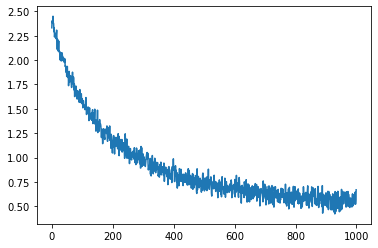

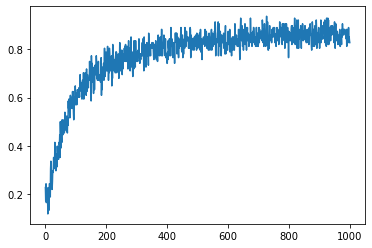

In [39]:
model = Net()
optimizer = SGD(model.parameters(), lr=1e-5)
criterion = NLLLoss()
epochs = 1000
batch_size = 128
losses = []
accs = []

for epoch in range(epochs):
    indices = np.random.randint(0, X_train.shape[0], size=(batch_size))
    samples = Tensor(X_train[indices])
    targets = Y_train[indices]
    
    logits = model(samples)
    loss = criterion(logits, targets)
    losses.append(loss.data)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    cat = np.argmax(logits.data, axis=-1)
    acc = (cat == targets).mean()
    accs.append(acc)

    
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()
plt.plot(accs)
!